<a href="https://colab.research.google.com/github/nebyu08/data_sc/blob/main/h_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
90+90

180

In [3]:
!pip install datasets -qqq
!pip install -U transformers -qqq
!pip install torch -qqq
!pip install revtok -qqq
!pip install torch-summary -qqq
!pip install accelerate -qqq

steps to follow:
* handling the classifier datasets
* making it into an iterator



# importing dependencies

In [4]:
import torch
import os
import pandas as pd
import re
import datasets
import string
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import nltk
import logging

from torch.utils.data import Subset
from collections import defaultdict
from torch.utils.data import random_split
from nltk.corpus import stopwords
from torch.utils.data import DataLoader,Dataset
from torchtext.data.utils import get_tokenizer
from torchsummary import summary
from transformers import RobertaTokenizer,RobertaModel,AutoModelForSequenceClassification,AutoTokenizer
from transformers import RobertaForSequenceClassification
from transformers import TrainingArguments,Trainer
from google.colab import userdata
from datasets import load_metric
from transformers import RobertaConfig
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import OneHotEncoder
from math import ceil

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
dataset=datasets.load_dataset("ucberkeley-dlab/measuring-hate-speech","default")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
#turn into a dataframe
df=dataset["train"].to_pandas()
df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [8]:
df.columns

Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_hindu', 'annotator_religion_jewish',
       'annotator_religion_mormon', 'annotator_religion_muslim',
       'annotator_religion_nothing', 'annotator_religion_other',
       'annotator_sexuality_bisexual', 'annotator_sexuality_gay',
       'annotator_sexuality_straight', 'annotator_sexuality_other'],
      dtype='object', length=131)

In [9]:
usefull_cols=[
              "text","hate_speech_score","sentiment","respect","insult","humiliate","status","dehumanize","violence","genocide","attack_defend","hatespeech"
              ]

In [10]:
#new dataframe
new_df=df[usefull_cols]

new_df.head()

,text,hate_speech_score,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
0,Yes indeed. She sort of reminds me of the elde...,-3.90,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,The trans women reading this tweet right now i...,-6.52,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
2,Question: These 4 broads who criticize America...,0.36,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,4.0,2.0
3,It is about time for all illegals to go back t...,0.26,2.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0
4,For starters bend over the one in pink and kic...,1.54,4.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,3.0,2.0


# lets draw some graphs here to analyze tha data


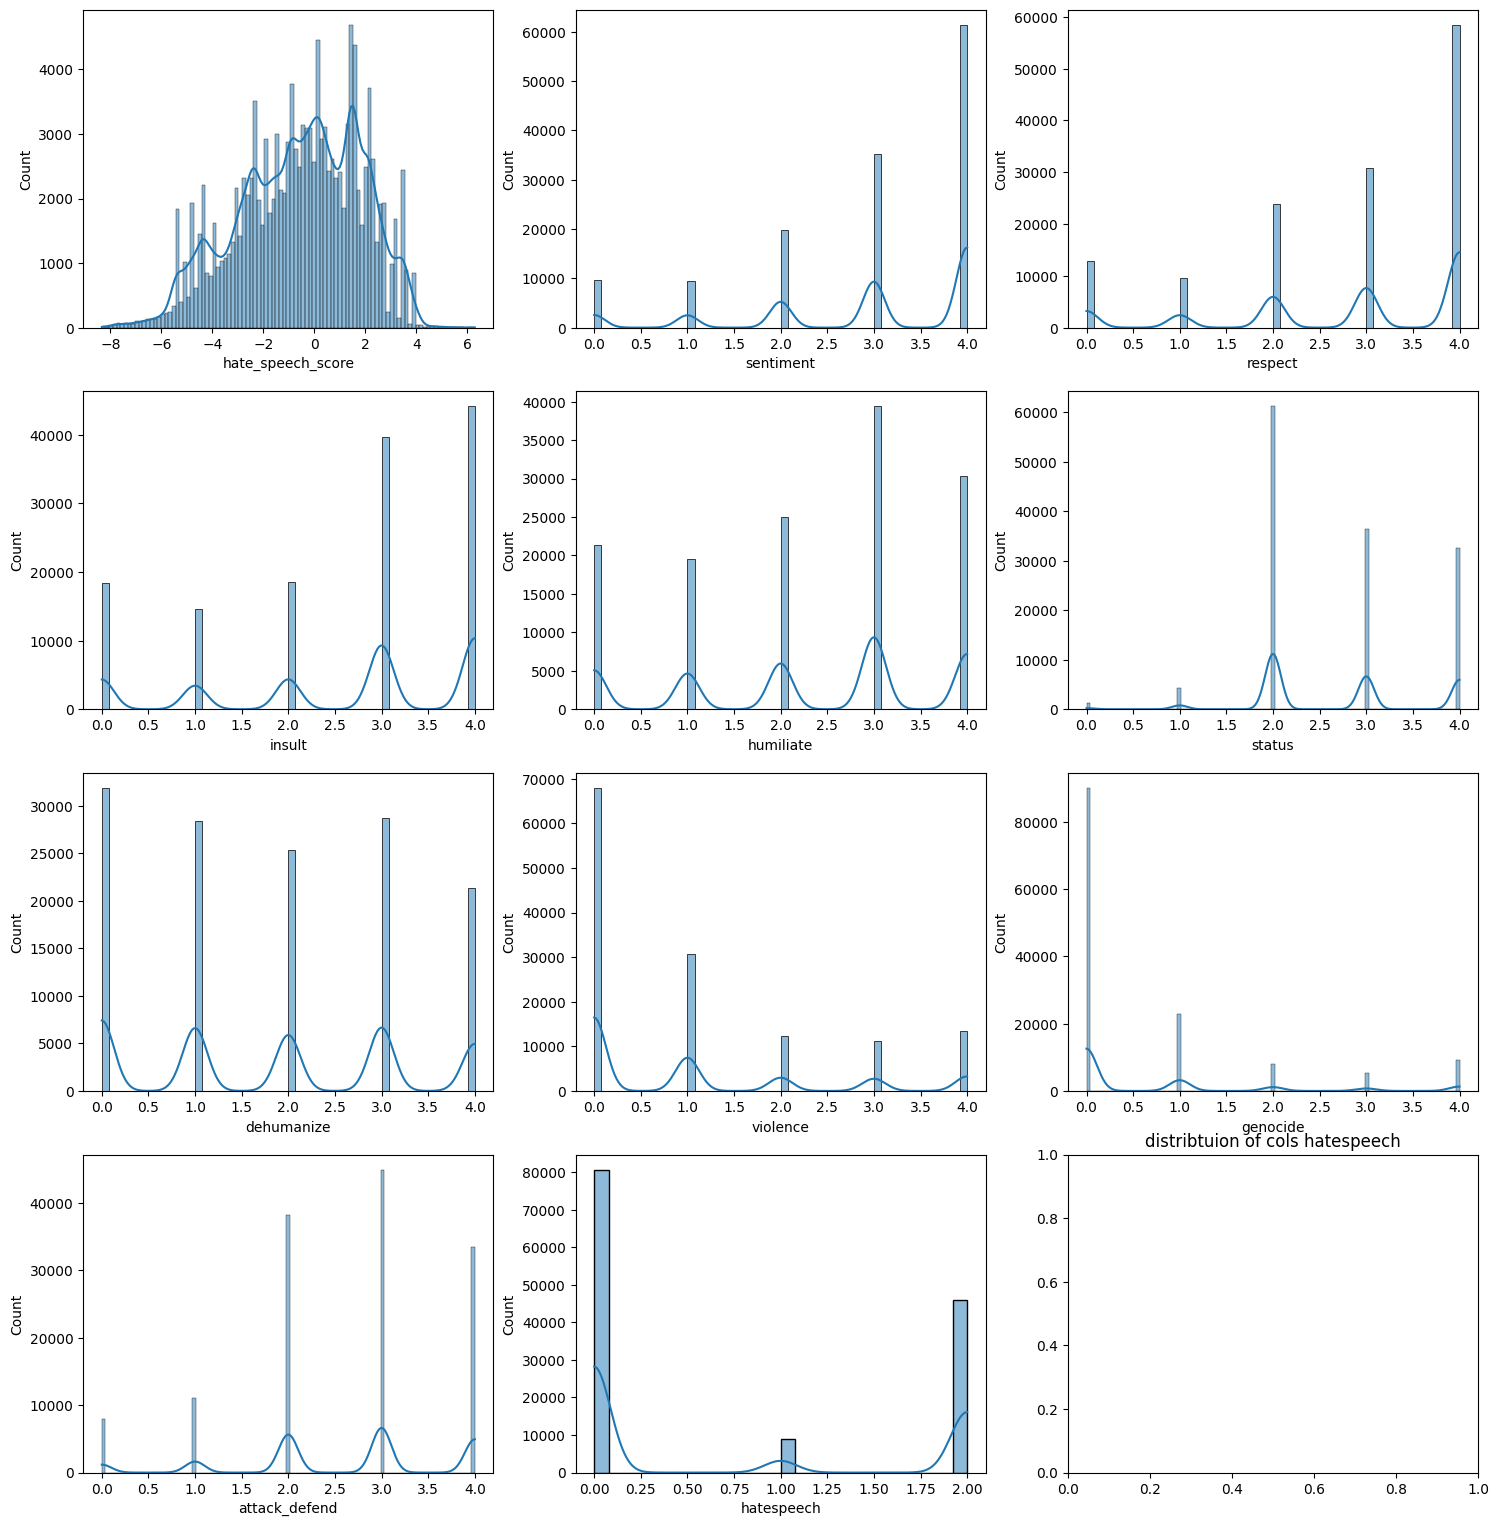

In [11]:
some_feature=[
              "hate_speech_score","sentiment","respect","insult","humiliate","status","dehumanize","violence","genocide","attack_defend","hatespeech"
              ]

num_feat=len(some_feature)
num_cols=3  #number of cols
num_row=(num_feat+num_cols-1)//num_cols

fig,axs=plt.subplots(num_row,num_cols,figsize=(18,19))

for val,cols in enumerate(some_feature):
  if val>=num_feat:
    break
  row=val//num_cols
  col=val%num_cols
  sns.histplot(new_df[cols],kde=True,ax=axs[row,col]);
  plt.title(f"distribtuion of cols {cols}");

In [12]:
print(new_df.violence.value_counts())

0.0    67922
1.0    30727
4.0    13404
2.0    12241
3.0    11262
Name: violence, dtype: int64


#lets visualize this datasets

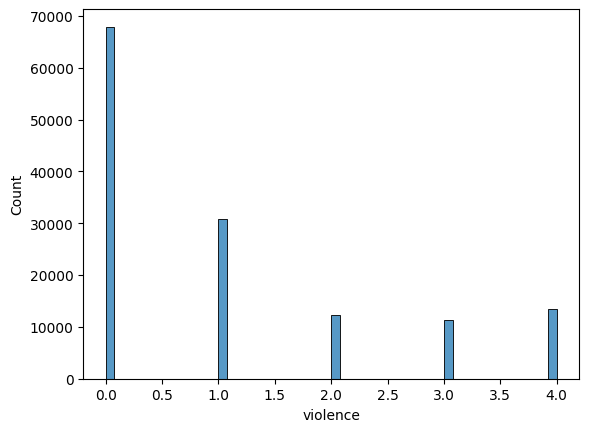

In [13]:
sns.histplot(data=new_df,x=new_df.violence);

<Axes: xlabel='hate_speech_score', ylabel='Count'>

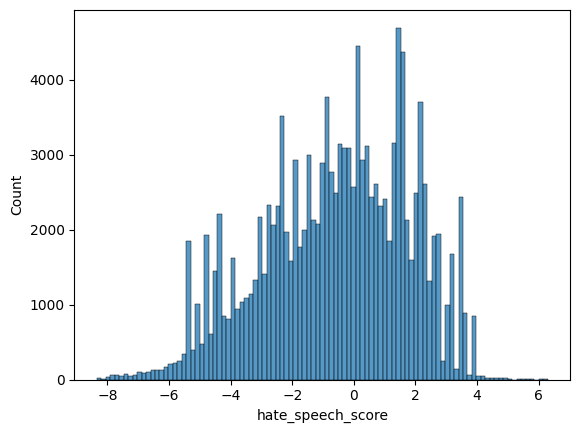

In [14]:
sns.histplot(data=new_df,x=new_df.hate_speech_score)

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135556 entries, 0 to 135555
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   text               135556 non-null  object 
 1   hate_speech_score  135556 non-null  float64
 2   sentiment          135556 non-null  float64
 3   respect            135556 non-null  float64
 4   insult             135556 non-null  float64
 5   humiliate          135556 non-null  float64
 6   status             135556 non-null  float64
 7   dehumanize         135556 non-null  float64
 8   violence           135556 non-null  float64
 9   genocide           135556 non-null  float64
 10  attack_defend      135556 non-null  float64
 11  hatespeech         135556 non-null  float64
dtypes: float64(11), object(1)
memory usage: 12.4+ MB


# clean the data

### lets change the dataset

In [16]:
data=new_df[["text","hate_speech_score"]]
data.head()

,text,hate_speech_score
0,Yes indeed. She sort of reminds me of the elde...,-3.90
1,The trans women reading this tweet right now i...,-6.52
2,Question: These 4 broads who criticize America...,0.36
3,It is about time for all illegals to go back t...,0.26
4,For starters bend over the one in pink and kic...,1.54


In [17]:
print(data.hate_speech_score.value_counts())

 2.73    1581
 2.14    1575
 2.10    1390
 2.27    1195
 0.12     982
         ... 
-6.81       1
-7.08       1
-8.14       1
 5.10       1
 6.01       1
Name: hate_speech_score, Length: 1255, dtype: int64


In [18]:
class Datasets(Dataset):
  def __init__(self,data,target):
    self.data=data
    self.target=target
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    return {
        "data":self.data[idx],
        "target":self.target[idx]
    }

In [19]:
# data=["this is my name","this is not hate speech","this is tho","what about this one"]
# target=torch.tensor([1,2,3,9],dtype=torch.float32)
# custom_dataset=Datasets(
#     data=data,
#     target=target
# )

#lets make it into a data loader
# target_dataloader=DataLoader(custom_dataset,
#                              batch_size=2,
#                              collate_fn=collate_fn
#                           )
# for batch in target_dataloader:
#   print(f"data is {batch['data']} and target is {batch['target']}")

In [20]:
def collate_fn(batch):
  data=[item["data"] for item in batch]
  target=torch.cat(item["target"] for item in batch)
  return {"data":data,"target":target}

In [21]:
#lets copy the original dataset
copy_data=data.copy()

In [22]:
conditions=[
   (copy_data["hate_speech_score"].astype(float)>0.5),
    (copy_data["hate_speech_score"].astype(float)<-1),
   ((copy_data["hate_speech_score"].astype(float)>=-1) & (copy_data["hate_speech_score"].astype(float) <=0.5))
]
values=["hate","supportive","neutral"]
copy_data["hate_speech_score"]=np.select(conditions,values,default=np.nan)

In [23]:
copy_data["hate_speech_score"].value_counts()

supportive    53651
hate          49048
neutral       32857
Name: hate_speech_score, dtype: int64

In [24]:
copy_data.head()

,text,hate_speech_score
0,Yes indeed. She sort of reminds me of the elde...,supportive
1,The trans women reading this tweet right now i...,supportive
2,Question: These 4 broads who criticize America...,neutral
3,It is about time for all illegals to go back t...,neutral
4,For starters bend over the one in pink and kic...,hate


In [25]:
len(copy_data)

135556

In [26]:
#45,  is wild
i=932
copy_data["text"][i],copy_data["hate_speech_score"][i]

("I actually would love to have their audacity. It's incredible. Send them to China for some slave labour. May wake them the hell up",
 'supportive')

# lets start the preprocessing

In [27]:
#column to onehot encode
column_encode=np.array(copy_data["hate_speech_score"]).reshape(-1,1)
#one hot encoding
encoder=OneHotEncoder(handle_unknown="ignore")
encoder.fit(column_encode)

#encode the column
encoded_column=encoder.transform(column_encode).toarray()

In [28]:
print(encoded_column)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [29]:
#turn the column into a df
temp_df=pd.DataFrame(encoded_column)
#new dataframe
encoded_df=pd.concat([copy_data,temp_df],axis=1)
encoded_df.drop(["hate_speech_score"],axis=1,inplace=True)
encoded_df.head()

,text,0,1,2
0,Yes indeed. She sort of reminds me of the elde...,0.0,0.0,1.0
1,The trans women reading this tweet right now i...,0.0,0.0,1.0
2,Question: These 4 broads who criticize America...,0.0,1.0,0.0
3,It is about time for all illegals to go back t...,0.0,1.0,0.0
4,For starters bend over the one in pink and kic...,1.0,0.0,0.0


In [30]:
#lets extract the maximum length in the column text
max_length=encoded_df["text"].str.len().max()
print(f"maximum length is {max_length}")

maximum length is 603


# lets make a new preprocessor of data here

In [31]:
# lets encode the target label
df=data.copy()

conditions=[
   (df["hate_speech_score"].astype(float)>0.5),
    (df["hate_speech_score"].astype(float)<-1),
   ((df["hate_speech_score"].astype(float)>=-1) & (df["hate_speech_score"].astype(float) <=0.5))
]
values=["hate","supportive","neutral"]
df["hate_speech_score"]=np.select(conditions,values,default=np.nan)

df.head()

,text,hate_speech_score
0,Yes indeed. She sort of reminds me of the elde...,supportive
1,The trans women reading this tweet right now i...,supportive
2,Question: These 4 broads who criticize America...,neutral
3,It is about time for all illegals to go back t...,neutral
4,For starters bend over the one in pink and kic...,hate


In [32]:
#lets do the inverse of the mapping
label2num={label:num for num,label in enumerate(df["hate_speech_score"].unique())}
num2label={num:label for num,label in enumerate(df["hate_speech_score"].unique())}

In [33]:
#lets encode the target label
mapping={label:num for  num,label in enumerate(df["hate_speech_score"].unique())}
df["hate_speech_score"]=df["hate_speech_score"].map(mapping)

In [34]:
copy_data.hate_speech_score.value_counts()

supportive    53651
hate          49048
neutral       32857
Name: hate_speech_score, dtype: int64

In [35]:
label2num,num2label

({'supportive': 0, 'neutral': 1, 'hate': 2},
 {0: 'supportive', 1: 'neutral', 2: 'hate'})

In [36]:
#setting up the maximum length of the model
max_length=512

In [37]:
#changed the max length of the model from 6
class Local_Dataset(Dataset):
  def __init__(self,data,target,max_length,tokenizer):
    self.data=data
    self.target=target
    self.tokenizer=tokenizer
    self.max_length=512

  def __len__(self):
    if len(self.data)==0:
      raise ValueError("hi...dataset is empty")
    else:

      return len(self.data)

  def __getitem__(self,idx):
    if idx>=len(self.data):
      raise  IndexError("index out of range.. can't access the element")

    data_indexed=self.data[idx]
    target_indexed=self.target[idx]

    encoding=self.tokenizer.encode_plus(
        data_indexed,
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    #thi is the what the dataset returns
    input_ids=encoding["input_ids"].flatten()
    attention_mask=encoding["attention_mask"].flatten()
    labels=torch.tensor(target_indexed,dtype=torch.long)

    #cheking for non empty tensors
    if input_ids.numel()==0 or attention_mask.numel()==0:
      raise ValueError(f"hi..there is an error in the tensor {idx}")

    return {
        #"text":data_indexed,
        "input_ids":input_ids,
        "attention_mask":attention_mask,
        "labels":labels
    }

## lets initial our tokenizer.

In [38]:
model_name="SamLowe/roberta-base-go_emotions"
tokenizer=AutoTokenizer.from_pretrained(model_name,max_length=max_length)

In [39]:
## lets initialize our model
model=RobertaModel.from_pretrained(model_name,
                                   id2label=num2label,
                                   label2id=label2num,
                                   num_labels=3) #3 is the number of classes

Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# my new model and tokenizer:
* this model can handle any text size: applying sliding window
* the bottom layer is frozen
* there is new last layer

In [40]:
# # the model and the tokenizer are the following
# config=RobertaConfig.from_pretrained(model_1_name)
# model_1=RobertaForSequenceClassification.from_pretrained(model_1_name,config=config)
# tokenizer_1=RobertaTokenizer.from_pretrained()        #tokenizer_1=RobertaTokenizer.from_pretrained(model_1_name,label2id=label2num,id2label=num2label)

In [41]:
#lets load the model and the tokenizer
model_1_name="roberta-base"
config=RobertaConfig.from_pretrained(model_1_name)

#adjust somestuff
config.label2id=label2num
config.id2label=num2label

model_1=RobertaForSequenceClassification.from_pretrained(model_1_name,config=config)
tokenizer_1=RobertaTokenizer.from_pretrained(model_1_name,config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
len(num2label)

3

#EDA for the model

In [43]:
plt.style.use("ggplot")

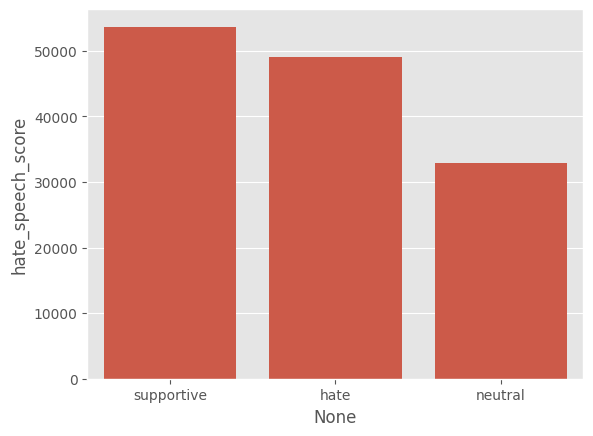

In [44]:
## what are the most common words for each target label
co=copy_data.hate_speech_score.value_counts()
sns.barplot(x=co.index,y=co)
plt.show()

In [45]:
mapping

{'supportive': 0, 'neutral': 1, 'hate': 2}

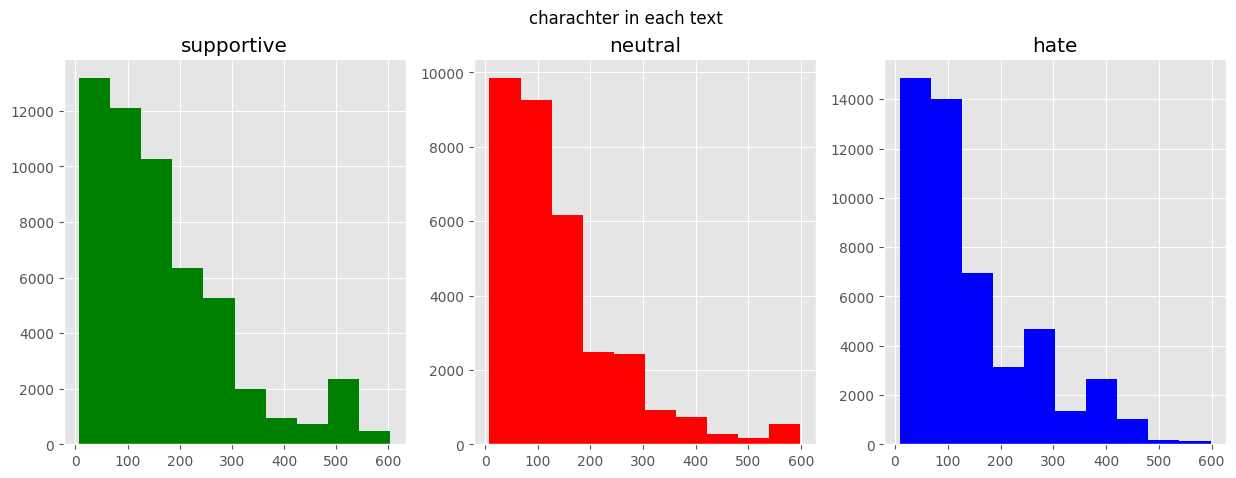

In [46]:
#number of charachters for each label
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
text_len=df[df["hate_speech_score"]==0]["text"].str.len()
ax1.hist(text_len,color="green")
ax1.set_title("supportive")

text_len=df[df["hate_speech_score"]==1]["text"].str.len()
ax2.hist(text_len,color="red")
ax2.set_title("neutral")

text_len=df[df["hate_speech_score"]==2]["text"].str.len()
ax3.hist(text_len,color="blue")
ax3.set_title("hate")
fig.suptitle("charachter in each text")
plt.show();

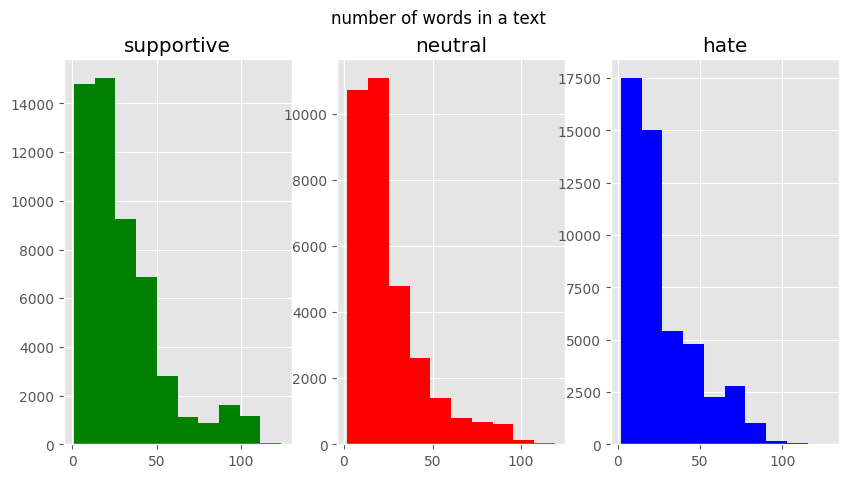

In [47]:
#number of words in a text
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
text_len=df[df["hate_speech_score"]==0]["text"].str.split().map(lambda x:len(x))
ax1.hist(text_len,color="green")
ax1.set_title("supportive")

text_len=df[df["hate_speech_score"]==1]["text"].str.split().map(lambda x:len(x))
ax2.hist(text_len,color="red")
ax2.set_title("neutral")

text_len=df[df["hate_speech_score"]==2]["text"].str.split().map(lambda x:len(x))
ax3.hist(text_len,color="blue")
ax3.set_title("hate")

fig.suptitle("number of words in a text")
plt.show();

# analysing stop words

In [48]:
#setting up the stopwords
stop_words=set(stopwords.words("english"))

In [49]:
#making corpus of words
def create_corps(target):
  corps=[]
  for x in df[df["hate_speech_score"]==target]["text"].str.split():
    for i in x:
      corps.append(i)
  return corps

In [50]:
mapping

{'supportive': 0, 'neutral': 1, 'hate': 2}

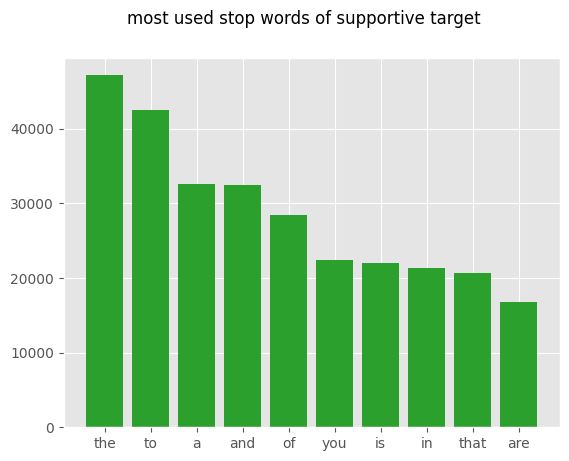

In [51]:
#for the supportive target
corps=create_corps(0)

counts=defaultdict(int)
for i in corps:
  if i in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x,y,color="tab:green")
plt.suptitle("most used stop words of supportive target");

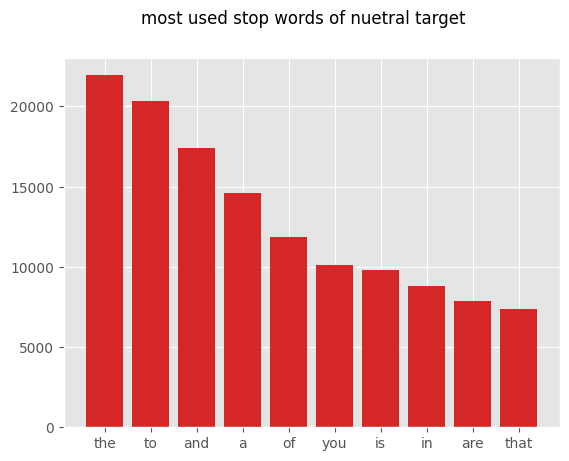

In [52]:
#for the supportive target
corps=create_corps(1)

counts=defaultdict(int)
for i in corps:
  if i in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x,y,color="tab:red")
plt.suptitle("most used stop words of nuetral target");

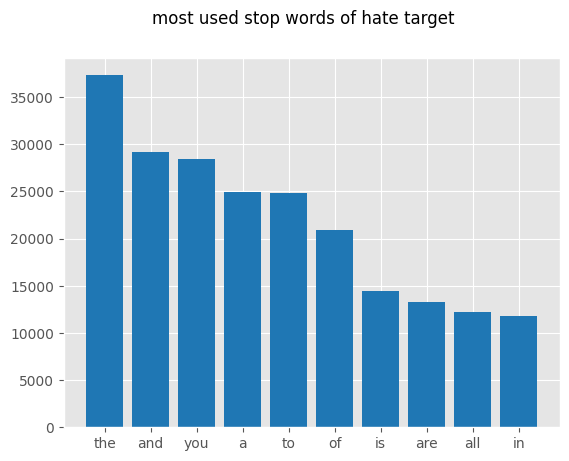

In [53]:
#for the supportive target
corps=create_corps(2)

counts=defaultdict(int)
for i in corps:
  if i in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x,y,color="tab:blue")
plt.suptitle("most used stop words of hate target");

## most common words of each target

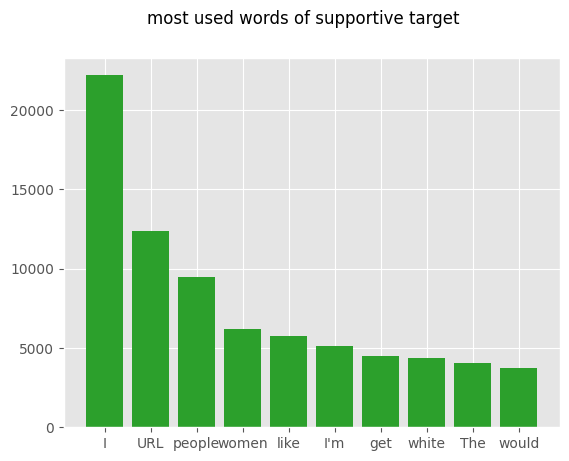

In [54]:
#for the supportive target
corps=create_corps(0)

counts=defaultdict(int)
for i in corps:
  if i not in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x,y,color="tab:green")
plt.suptitle("most used words of supportive target");

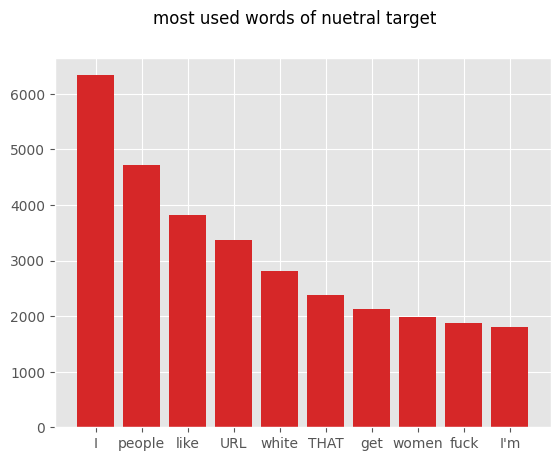

In [55]:
#for the supportive target
corps=create_corps(1)

counts=defaultdict(int)
for i in corps:
  if i not in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x,y,color="tab:red")
plt.suptitle("most used words of nuetral target");

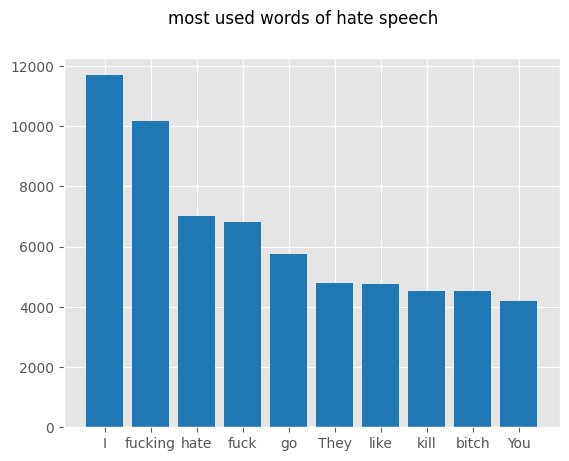

In [56]:
#for the supportive target
corps=create_corps(2)

counts=defaultdict(int)
for i in corps:
  if i not in stop_words:
    counts[i]+=1

#extracting the maximum amount of used words
most_used=sorted(counts.items(),key=lambda x:x[1],reverse=True)[:10]  #choosing the top-10

#lets plot a graph
x,y=zip(*most_used)
plt.bar(x=x,height=y,color="tab:blue")
plt.suptitle("most used words of hate speech");

## checking for punctuations

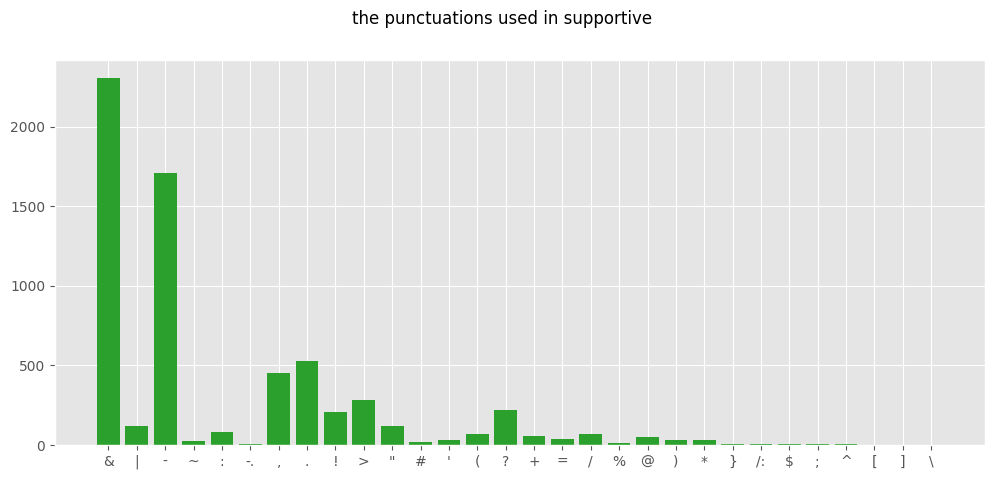

In [57]:
#checking for the supportive group of texts
plt.figure(figsize=(12,5))
corps=create_corps(0)
punctuations=string.punctuation
punc_counts=defaultdict(int)

for i in corps:
  if i in punctuations:
    punc_counts[i]+=1

x,y=zip(*punc_counts.items())
plt.bar(x,y,color="tab:green")
plt.suptitle("the punctuations used in supportive ")
plt.show();

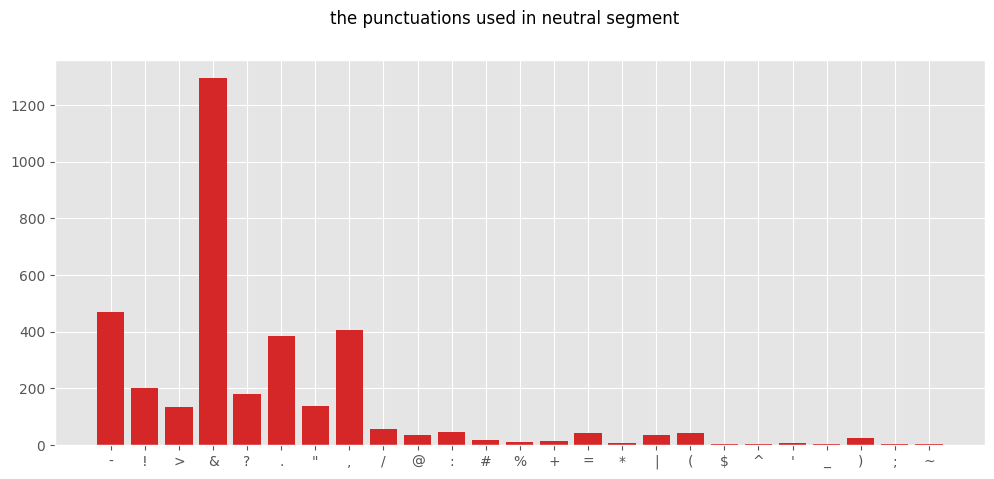

In [58]:
#checking for the supportive group of texts
plt.figure(figsize=(12,5))
corps=create_corps(1)
punctuations=string.punctuation
punc_counts=defaultdict(int)

for i in corps:
  if i in punctuations:
    punc_counts[i]+=1

x,y=zip(*punc_counts.items())
plt.bar(x,y,color="tab:red")
plt.suptitle("the punctuations used in neutral segment")
plt.show();

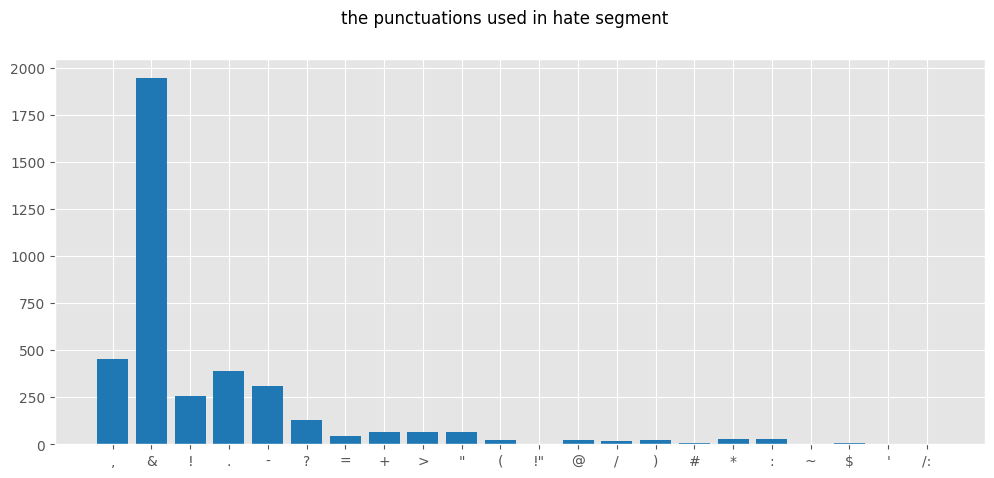

In [59]:
#checking for the supportive group of texts
plt.figure(figsize=(12,5))
corps=create_corps(2)
punctuations=string.punctuation
punc_counts=defaultdict(int)

for i in corps:
  if i in punctuations:
    punc_counts[i]+=1

x,y=zip(*punc_counts.items())
plt.bar(x,y,color="tab:blue")
plt.suptitle("the punctuations used in hate segment")
plt.show();

# clean the dataset

# removing some element of the text:
* emoji
* punctuations
* urls and html tags

In [60]:
#this is our working dataset
main_df=df.copy()

In [61]:
main_df

,text,hate_speech_score
0,Yes indeed. She sort of reminds me of the elde...,0
1,The trans women reading this tweet right now i...,0
2,Question: These 4 broads who criticize America...,1
3,It is about time for all illegals to go back t...,1
4,For starters bend over the one in pink and kic...,2
...,...,...
135551,عاجل سماحة #السيد_عبدالملك_بدرالدين_الحوثي نص...,0
135552,Millions of #Yemen-is participated in mass ral...,0
135553,@AbeShinzo @realDonaldTrump @shinzoabe 独裁者は行きま...,0
135554,Millions of #Yemen-is participated in mass ral...,0


In [62]:
#removing the emoji's
def remove_emoji(text):
  emoji_pattern=re.compile("["
      u"\U0001F600-\U0001F644F"
      u"\U0001F300-\U0001F5FF"
      u"\U0001F680-\U0001F6FFF"
      u"\U0001F1E0-\U0001F1FF"
      "]+",flags=re.UNICODE)

  return emoji_pattern.sub(r'',text)

#apply the regex expression
main_df["text"]=main_df["text"].apply(lambda x:remove_emoji(x))

In [63]:
#removing punctuations
def remove_punctuations(text):
  remove_punctuations=dict.fromkeys(map(ord,string.punctuation)) #this is lookup table
  clean_text=text.translate(remove_punctuations)
  return clean_text

main_df["text"]=main_df["text"].apply(lambda x:remove_punctuations(x))

In [64]:
#removing urls and html tags
def remove_urls(text):
  remove_urls=re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  cleaned_text=re.sub(remove_urls,"",text)
  return cleaned_text
main_df["text"]=main_df["text"].apply(lambda x:remove_urls(x))

In [65]:
def remove_non_english(text):
  remove_pattern=re.compile("[^\u0000-\u05C0\u2100-\u214F]+")
  clean_text=re.sub(remove_pattern,"",text)
  return clean_text

main_df["text"]=main_df["text"].apply(lambda x:remove_non_english(x))

In [66]:
main_df

,text,hate_speech_score
0,Yes indeed She sort of reminds me of the elder...,0
1,The trans women reading this tweet right now i...,0
2,Question These 4 broads who criticize America ...,1
3,It is about time for all illegals to go back t...,1
4,or starters bend over the one in pink and kick...,2
...,...,...
135551,BreakingNews Sayyed AbdulmalikT...,0
135552,Millions of Yemenis participated in mass ralli...,0
135553,AbeShinzo realDonaldTrump shinzoabe Dictator ...,0
135554,Millions of Yemenis participated in mass ralli...,0


In [99]:
p=np.random.randn(90,6)
temp=pd.DataFrame(p)

In [103]:
temp.head()

,0,1,2,3,4,5
0,-1.111458,0.246505,0.498222,1.140149,1.580541,-1.015094
1,-0.810858,-1.257578,-0.234020,0.466358,0.987335,-0.075951
2,-0.319848,0.151758,-0.835143,2.089539,-1.607661,0.184741
3,2.023606,0.006800,-0.190039,-0.357445,-0.180392,1.372848
4,-2.211862,1.533434,-1.423957,-0.266652,-0.429244,0.588553


# making model

In [67]:
# Define a custom classification head

#freeze the bottom layer
for param in model_1.parameters():
  param.requires_grad=False

num_labels=len(label2num)
class CustomClassifier(nn.Module):
    def __init__(self, config,num_labels):
        super().__init__()
        self.num_labels=num_labels
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob,inplace=True)
        self.out_proj = nn.Linear(config.hidden_size, self.num_labels)

        #lets initiate the weights
        torch.nn.init.xavier_normal_(self.dense.weight)
        torch.nn.init.xavier_normal_(self.out_proj.weight)


    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        x=nn.Softmax(dim=-1)(x)  #applies the softmax into the last layer
        return x

#remove the last layer
model_1.classifier=nn.Identity()

# Replace the pre-trained head with your custom head
custom_layer=CustomClassifier(config,num_labels)

for param in custom_layer.parameters():
  param.requires_grad=True

#the new integrated layer
model_1.classifier=custom_layer

In [68]:
model_1.classifier

CustomClassifier(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=True)
  (out_proj): Linear(in_features=768, out_features=3, bias=True)
)

In [69]:
#setting up the window sliding method
def sliding_window(token_ids,window_size,step_size):
  return [token_ids[i:i+window_size] for i in range(0,len(token_ids),step_size) if i+window_size <=len(token_ids)]

# lets make a new datasets and datalaoder
class CustomDataset_with_sliding_window(Dataset):
  def __init__(self,text,labels,tokenizer,window_size,step_size):
    super().__init__()
    self.text=text
    self.labels=labels
    self.tokenizer=tokenizer
    self.window_size=window_size
    self.step_size=step_size

  def __len__(self):
      return len(self.text)

  def __getitem__(self,idx):
    text=self.text[idx]
    label=self.labels[idx]
    token_ids=self.tokenizer.encode(text,add_special_tokens=True)

    #applying the sliding window
    windows=sliding_window(token_ids,self.window_size,self.step_size)
    inputs_processed=[self.tokenizer.prepare_for_model(window,
                                                       add_special_tokens=False,
                                                       max_length=self.window_size,
                                                       padding="max_length",
                                                       return_tensors="pt") for window in windows
    ]

    #lets set the things that are supposed to be returned
    # input_ids=torch.stack([i["input_ids"].squeeze() for i in inputs_processed if i["input_ids"].numel()>0])
    # attention_mask=torch.stack([i["attention_mask"].squeeze() for i in inputs_processed if i["attention_mask"].numel()>0])
    # labels=torch.tensor(label,dtype=torch.long)

    #lets try someform of debugging of this code
    input_ids = []
    attention_mask = []

    for i in inputs_processed:
        if "input_ids" in i and "attention_mask" in i:
            if i["input_ids"].numel() > 0 and i["attention_mask"].numel() > 0:
                input_ids.append(i["input_ids"].squeeze())
                attention_mask.append(i["attention_mask"].squeeze())

    if not input_ids:
      input_ids.append(torch.zeros(1,self.window_size))

    if not attention_mask:
      attention_mask.append(torch.zeros(1,self.window_size))


    return{
        "input_ids":torch.stack(input_ids) if input_ids else torch.zeros((1,self.window_size)),
        "attention_mask":torch.stack(attention_mask) if attention_mask else torch.zeros((1,self.window_size)),
        "labels":torch.tensor(label,dtype=torch.long)
    }

In [70]:
# lets make a new datasets and datalaoder
class CustomDataset(Dataset):
  def __init__(self,text,labels,tokenizer,max_length=512):
    super().__init__()
    self.text=[i for i in text if i.strip()]   #filter out empty strings
    self.text_labels=[(t,l) for t,l in zip(text,labels)]
    #another layer of debugging
    if not self.text:
      raise ValueError("the data is empty")

    self.labels=labels if isinstance(labels,list) else labels.tolist()
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
      return len(self.text_labels)

  def __getitem__(self,idx):
    text=self.text[idx]
    label=self.labels[idx]
    token_ids=self.tokenizer.encode_plus(text,
                                    add_special_tokens=True,
                                    max_length=self.max_length,
                                    truncation=True,
                                    padding="max_length",
                                    return_tensors="pt",
                                    return_attention_mask=True,
                                    return_token_type_ids=True
                                    )
    #fill the empty row with somthing
    if token_ids["input_ids"].sum().item() == 0:
      token_ids["input_ids"] = torch.full((1,), self.tokenizer.pad_token_id, dtype=torch.long)
      token_ids["attention_mask"]=torch.zeros_like(token_ids["input_ids"])

    # #the test and the labels are
    # some_text=self.text
    # some_label=self.labels
    # print(f"text:{text}")
    # print(f"label:{label}")


    return_dict={
        "input_ids":token_ids["input_ids"].flatten(),
        "attention_mask":token_ids["attention_mask"].flatten(),
        "labels":torch.tensor(label,dtype=torch.long)
    }

    #lets print the input ids ,attention mask and labels
    # print(f"input ids:{return_dict['input_ids']}")
    # print(f"attention_mask:{return_dict['attention_mask']}")
    # print(f"the labels are {return_dict['labels']}")

    return return_dict

In [71]:
#making compiled model for faster training
compiled_model1=torch.compile(model_1)

In [72]:
compiled_model1

OptimizedModule(
  (_orig_mod): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (de

In [73]:
#let setup the dataset for training our dataset
x=main_df["text"]
y=main_df["hate_speech_score"]

all_data=CustomDataset(
                       text=x,
                       labels=y,
                       tokenizer=tokenizer_1
                       )

In [74]:
#spliting the values into training,validating and testing
#lets the seed the spliter
generator=torch.Generator().manual_seed(42)

train_size=int(0.75*len(data))
valid_size=int(0.15*len(data))
test_size=int(len(data)-(train_size+valid_size))

train_dataset,valid_dataset,test_dataset=random_split(all_data,[train_size,valid_size,test_size],generator=generator)

In [75]:
batch_size=16 #temporarly change the batch size
#lets turn them into dataloaders
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_dataloader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [76]:
len(train_dataset),len(valid_dataset),len(test_dataset)

(101667, 20333, 13556)

In [77]:
len(train_dataloader),len(valid_dataloader),len(test_dataloader)

(6355, 1271, 848)

# experimentation with code

In [78]:
#lets see what the tokenizer return for dummt data
text="this is not the end"
encoded_text=tokenizer_1.encode_plus(text,
                                padding="max_length",
                                truncation=True,
                                max_length=512,
                                return_tensors="pt")

input_idss=encoded_text["input_ids"]
attention_maskss=encoded_text["attention_mask"]

print(f"the input ids are: {input_idss.shape}")
print(f"the attentoin heads are {attention_maskss.shape}")
print(f"number of elements {input_idss.numel()}")

the input ids are: torch.Size([1, 512])
the attentoin heads are torch.Size([1, 512])
number of elements 512


In [79]:

#encoding algorithm
def encode_text(text):
  text_encoded=tokenizer_1.encode_plus(
      text,
      padding="max_length",
      truncation=True,
      max_length=512,
      return_tensors="pt"
  )
  return text_encoded

#sample encode of some value of the dataframe
sample=main_df[:100]
sample["encoded_text"]=sample["text"].apply(lambda x:encode_text(x))

<ipython-input-79-191a0fdc1836>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["encoded_text"]=sample["text"].apply(lambda x:encode_text(x))


In [80]:
#lets see how the decoding works
def decode_to_ids(encoded):
  return encoded["input_ids"].squeeze()

def decode_to_attention(encoded):
  return encoded["attention_mask"].squeeze()

sample["input_ids"]=sample["encoded_text"].apply(lambda x:decode_to_ids(x))
sample["attention_mask"]=sample["encoded_text"].apply(lambda x:decode_to_attention(x))

<ipython-input-80-a60bef5ace4d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["input_ids"]=sample["encoded_text"].apply(lambda x:decode_to_ids(x))
<ipython-input-80-a60bef5ace4d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["attention_mask"]=sample["encoded_text"].apply(lambda x:decode_to_attention(x))


# experiment with some samples data's

In [81]:
train_dataset[1001]["attention_mask"]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# experiment with the model it self

In [82]:
copy_model_path="copied_model.pt"
torch.save(model_1.state_dict(),copy_model_path)

#copied model
copy_model=model_1.__class__(config)

copy_model.load_state_dict(torch.load(copy_model_path))

<All keys matched successfully>

In [83]:
subsets=Subset(train_dataset,
               indices=[12,43,32])
subsets[0]["input_ids"]

tensor([    0,   487,  3847,   114,     5,   129,   631,    47,   101,    59,
           42,   247,    16,     5,   481,  3717,     8,    14,    51,  1994,
         2370,    47,   197, 26536,   160,  1437,  3216,  1816,  4538,     5,
         8681,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

## train on a small dataset

In [84]:
for i,batch in enumerate(train_dataloader):
  break

In [85]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [86]:
copy_model=copy_model.to(device)

In [87]:
# counter=main_df["text"].str.split()

In [88]:
# optimizer=torch.optim.AdamW(copy_model.parameters(),
#                        lr=0.01)

# loss_fn=nn.CrossEntropyLoss()

# #prepare dataset and dataloader subset
# subsets=Subset(all_data,
#                 indices=range(0,1000))

# subset_loader=DataLoader(subsets,
#                          batch_size=10,
#                          shuffle=True)

# tot_loss=0
# num_epochs=2
# #lets train the model

# for i in range(num_epochs):
#   print(f"training {i}/{num_epochs}")
#   for batch in subset_loader:
#     input_ids=batch["input_ids"].to(device)
#     attention_mask=batch["attention_mask"].to(device)
#     labels=batch["labels"].to(device)

#     outputs=copy_model(input_ids,
#                        attention_mask)

#     logits=outputs.logits

#     #zeros the accumulated loss..
#     optimizer.zero_grad()

#     #calculate the loss...
#     print(f"loss is {loss}")
#     loss=loss_fn(logits,labels)
#     tot_loss+=loss

#     #back propagate
#     loss.backward()
#     #update the parameters
#     optimizer.step()

In [89]:
#clear cache and gpu ram
torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_statistics()

In [116]:
tokenizer_1.encode("")

[0, 2362, 10, 10080, 102, 429, 29, 2]

# training the model

In [91]:
#setting up the metric for model evaluation
def custom_metrics(tobe_evaluated):
  logits,labels=tobe_evaluated  #this is the logits and labels
  predictions=logits.argmax(dim=-1)  #making sure that we choosing along the last dimension
  #loading the metrics
  accuracy=load_metric("accuracy")
  precision=load_metric("precission")
  f1_score=load_metric("f1")
  recall=load_metric("recall")

  #calculating the metrics
  acc=accuracy.compute(predictions,reference=labels)
  prc=precision.compute(predictions,reference=labels,average='macro')
  f1=f1_score.compute(predictions,reference=labels,average='macro')
  re=recall.compute(predictions,reference=labels,average='macro')

  return {
      "accuracy":acc['accuracy'],
      "precision":acc["precision"],
      "recall":re["recall"],
      "f1":f1_score["f1"]
  }
batch_size=64
#setting up the training argument
training_args=TrainingArguments(
    output_dir='./h_classifier',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
    push_to_hub=True,
    hub_model_id="nebiyu29/hate_classifier",
    hub_token=userdata.get("new_token"),
    load_best_model_at_end=True,
)

In [92]:
#lets train the model
#set up the trainer....the trainer accepts datasets not dataloaders
trainer=Trainer(
    model=compiled_model1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=custom_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [93]:
  # trainer.train()

ValueError: The batch received was empty, your model won't be able to train on it. Double-check that your training dataset contains keys expected by the model: args,kwargs,label_ids,label.

# lets clean the data and prepate the dataset and data loader

In [117]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [118]:
expression=re.compile(r"[a-z][A-Z]")

def clean_text(text):

  return re.sub(expression," ",text)

In [119]:
df["text"]=df["text"].apply(clean_text)

In [120]:
x=df["text"]
y=df["hate_speech_score"]

#lets encode the text

# x_train_all,x_test,y_train_all,y_test=train_test_split(x,
#                                                        y,
#                                                test_size=0.2,
#                                                       random_state=42)

# #seperating into a traingin and validation
# x_train,x_val,y_train,y_val=train_test_split(x_train_all,
#                                              y_train_all,
#                                              test_size=0.2,
#                                              random_state=42)

#all the data's dataset
main_dataset=Local_Dataset(
    data=x,
    target=y,
    tokenizer=tokenizer,
    max_length=max_length
)

#lets the seed the spliter
generator=torch.Generator().manual_seed(42)

train_size=int(0.75*len(df))
valid_size=int(0.15*len(df))
test_size=int(len(df)-(train_size+valid_size))

train_dataset,valid_dataset,test_dataset=random_split(main_dataset,[train_size,valid_size,test_size],generator=generator)


#turn this into a dataset
# train_dataset=Local_Dataset(data=x_train,
#                             target=y_train,
#                             tokenizer=tokenizer,
#                             max_length=max_length
#                             )
# valid_dataset=Local_Dataset(
#                     data=x_val,
#                     target=y_val,
#                     tokenizer=tokenizer,
#                     max_length=max_length
# )
# test_dataset=Local_Dataset(
#                 data=x_test,
#                 target=y_test,
#                 tokenizer=tokenizer,
#                 max_length=max_length
# )

batch_size=64
num_count=os.cpu_count()

#turn the dataset into a dataloader
train_dataloader=DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
valid_dataloader=DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_dataloader=DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

In [121]:
# lets check out the dataset
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

101667
20333
13556


In [122]:
#checking for some values of the fist batch in the training
sample=train_dataset[1003]
print(f"the input ids are: {len(sample['input_ids'])}")
print(f"the attention masks are: {len(sample['attention_mask'])}")
#print(f"the output labels are: {sample['labels']}")

the input ids are: 512
the attention masks are: 512


In [123]:
#checking for validation datset
sample=valid_dataset[103]
print(f"the input ids are: {len(sample['input_ids'])}")
print(f"the attention masks are: {len(sample['attention_mask'])}")
#print(f"the output labels are: {sample['labels']}")

the input ids are: 512
the attention masks are: 512


In [124]:
#checking for testing datset
sample=test_dataset[1043]
print(f"the input ids are: {len(sample['input_ids'])}")
print(f"the attention masks are: {len(sample['attention_mask'])}")
#print(f"the output labels are: {sample['labels']}")

the input ids are: 512
the attention masks are: 512


In [125]:
len(train_dataset),len(valid_dataset),len(test_dataset)

(101667, 20333, 13556)

In [126]:
train_dataset,valid_dataset,test_dataset

(<torch.utils.data.dataset.Subset at 0x793f6fe2bf40>,
 <torch.utils.data.dataset.Subset at 0x793f6fe288b0>)

In [127]:
train_dataloader,valid_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x793f6fe2b250>,
 <torch.utils.data.dataloader.DataLoader at 0x793f6fe2a9e0>)

# lets see the model that is being finetuned


In [128]:
for batch in train_dataloader:
  input_data=batch['input_ids']
  target_data=batch['labels']
  attention=batch['attention_mask']
  break
print(input_data.shape)
print(target_data.shape)
print(input_data[0].size())
print(input_data[1].size())

torch.Size([64, 512])
torch.Size([64])
torch.Size([512])
torch.Size([512])


* figure out the last layers shape throgut the input shape that is given to the model

In [129]:
for batch in valid_dataloader:
  input_ids=batch['input_ids']
  target=batch['labels']
  break
print(input_ids.shape)
print(target.shape)

torch.Size([64, 512])
torch.Size([64])


In [130]:
for batch in test_dataloader:
  input_ids=batch['input_ids']
  attention=batch['attention_mask']
  target=batch['labels']
  break
print(input_ids.shape[1])
print(target.shape)
print(attention.shape)

512
torch.Size([64])
torch.Size([64, 512])


* TODO:
  * freeze all the layer and make a new local layer
  * add new local layer

### freeze all the base layer

In [131]:
#checking for the parameter of the model
model_param=sum(layer.numel() for layer in model.parameters())
print(f"model param is:{model_param/1e6:.2f}M")

model param is:124.65M


In [132]:
#create new layer from previous
class new_layer(nn.Module):
  """this is if you want to add a new layer with out deleting anything from the
     base model"""

  def __inti__(self,input_dim,hidden_dim,output_dim):
    super().__init__()
    self.l1=nn.Linear(input_dim,hidden_dim)
    self.l2=nn.Linear(hidden_dim,output_dim)
    self.act=nn.Softmax(dim=1)
  def forward(self,x):
    return self.act(self.l2(self.l1(x)))

In [133]:
#this is for freezing the last layer and adding my own local layer
with torch.no_grad():
  for param in model.parameters():
    param.requires_grad=False

#check if the model has a layer called pooler
if hasattr(model,"pooler"):
  setattr(model,"pooler",None)

#create a new layers
hidden_size=512  #nothing special about this number
labels=len(label2num)
custom_layer=nn.Sequential(
    nn.Linear(model.config.hidden_size,hidden_size),
    nn.ReLU(inplace=True),
    nn.Linear(hidden_size,labels),
    nn.Dropout(p=0.2),
    nn.Softmax(dim=1)
)

model.classifier=custom_layer

In [134]:
# inputs_shape=input_ids.size()
# attention_shape=attention.size()

# #input_data=[(inputs_shape,attention_shape)]

# #tuple verison of the above code
# inputs_int=tuple(map(int,input_data[0].size()))
# attention_shape=tuple(map(int,attention_shape))

# #expected shape
# new_input=(batch_size,max_length)
# new_input=tuple(map(int,new_input))

# model.to(device)
# summary(model,
#         input_data=new_input,
#          col_names=["input_size","output_size","num_params","kernel_size"]
#          )

## moving the dataset and model into gpu or device

In [135]:
model.to(device)
print("WE DONT NEED TO MOVE THE DATASET SINCE THE TRAINER HANDLES THAT PART")

WE DONT NEED TO MOVE THE DATASET SINCE THE TRAINER HANDLES THAT PART


# lets make our model compiled model

In [136]:
compiled_model=torch.compile(model)
compiled_model.to(device)
#the new model
compiled_model_1=torch.compile(model_1)
compiled_model_1.to(device)

OptimizedModule(
  (_orig_mod): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (de

# setting up the autotrain and trainer for training

In [137]:
#setting up the metric for model evaluation
def custom_metrics(tobe_evaluated):
  logits,labels=tobe_evaluated  #this is the logits and labels
  predictions=logits.argmax(dim=-1)  #making sure that we choosing along the last dimension
  #loading the metrics
  accuracy=load_metric("accuracy")
  precision=load_metric("precission")
  f1_score=load_metric("f1")
  recall=load_metric("recall")

  #calculating the metrics
  acc=accuracy.compute(predictions,reference=labels)
  prc=precision.compute(predictions,reference=labels,average='macro')
  f1=f1_score.compute(predictions,reference=labels,average='macro')
  re=recall.compute(predictions,reference=labels,average='macro')

  return {
      "accuracy":acc['accuracy'],
      "precision":acc["precision"],
      "recall":re["recall"],
      "f1":f1_score["f1"]
  }

#setting up the training argument
training_args=TrainingArguments(
    output_dir='./h_classifier',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
    push_to_hub=True,
    hub_model_id="nebiyu29/hate_classifier",
    hub_token=userdata.get("new_token"),
    load_best_model_at_end=True,
)

In [138]:
#set up the trainer....the trainer accepts datasets not dataloaders
trainer=Trainer(
    model=model,
    args=training_args,  #train_dataset,valid_dataset,test_dataset
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=custom_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [139]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
#push the model to hub
trainer.push_to_hub()